In [1]:
import os
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import itertools as it
import pandas as pd

from Env_IteratedPrisonersDilemma import IteratedPrisonersDilemma as IPD
from aux_functions import obtain_simdata
from aux_functions import _transform_tensor_into_hash

In [3]:
from learningdynamics.learningdynamics_jax import memomeanfield_valueSARSA as jvSARSA
from learningdynamics.learningdynamics_jax import multiagent_epsilongreedy_policy as MAEGpol

## inital conditions

In [4]:
from skopt.sampler import Lhs
from skopt.space import Space

def create_inital_lhs(number, iterations=1000):
    """Latin hyper cubed initial conditions"""
    space = Space(16*[(0.0, 1.0)])
    lhs = Lhs(criterion="maximin", iterations=iterations)
    x = lhs.generate(space.dimensions, number, random_state=42)
    values = np.array(x).reshape(number, 2, 4, 2)
    return values


## Simulation 
using value SARSA

### Functions

In [5]:
def trajectory_average_level_of_cooperation(AEi, pol, qtraj):
    cooperations = []
    for k in range(len(qtraj)):
        X = pol.action_probabilities(qtraj[k])
        finX = X
        Ps = AEi.statedist(X)
        Ci = np.einsum(finX, [0, 1, 2], Ps, [1], [0, 2])[:, 0]
        cooperations.append(Ci)
    return np.mean(cooperations)

def ensemble_average_level_of_cooperation(AEi, pol, qtrajs, cycles):
    coop = []
    for k in range(len(qtrajs)):
        avglen = 1 if not cycles[k] else 50
        coop.append(trajectory_average_level_of_cooperation(
            AEi, pol, qtrajs[k][-avglen:]))
        
    return np.mean(coop)

def obtain_strategysequence(qtraj, is_cycle=False):
    if is_cycle:
        stratseq = [str(q).replace('[', '').replace(']', '').replace('.', '').replace(' ', '')
            for q in (1 - np.argmax(qtraj, axis=-1))[800:1000].reshape(200,8)]

        cyc = np.array(stratseq)
        nums = np.ones_like(cyc, dtype=int) * -1

        unis = np.unique(cyc)
        for k in range(len(unis)):
            nums[np.where(cyc == unis[k])[0]] = k

        # see: https://stackoverflow.com/questions/44803225/find-likeliest-periodicity-for-time-series-with-numpys-fourier-transform
        w = np.fft.fft(nums)
        numreps = np.argmax(np.absolute(w)[1:-1])+1
        periodlen = np.round(200 / numreps, 0)
    
        stratseq = cyc[0:int(periodlen)]
    else:
        stratseq = [str(q).replace('[', '').replace(']', '').replace('.', '').replace(' ', '')
            for q in (1 - np.argmax(qtraj, axis=-1))[-1].reshape(1,8)]
    return stratseq

def ensemble_strategies(qtrajs, cycles):
    wsls = 0
    gt = 0
    alld = 0
    total = len(qtrajs)
    for k in range(total):
        if cycles[k]:
            continue
        else:
            stratseq = obtain_strategysequence(qtrajs[k])[0]
            wsls += stratseq == '10011001'
            gt += stratseq == '10001000'
            alld += stratseq == '00000000'
            
    result = dict(WSLS=wsls>0, GT=gt>0, ALLD=alld>0,
                  avgWSLS=wsls/total, avgGT=gt/total, avgALLD=alld/total)
    return result


def compute_extended_cooperation_grid(env, init_values, learningrates,
                                      explorationrates, discountfactors, 
                                      Tmax=3000):

    Ix = pd.MultiIndex.from_product((learningrates, explorationrates, 
                                     discountfactors), names=['lr', 'er', 'df'])
    df = pd.DataFrame(index=Ix, columns=['Cooperation', 'avgWSLS', 'avgGT',
                                         'avgALLD', 'WSLS', 'GT', 'ALLD'])

    for alph in learningrates:
        for eps in explorationrates:
            for gam in discountfactors:
                print("===== ", alph, eps, gam, " =====")
            
                pol = MAEGpol(epsilon_greedys=eps, N=2)    
                AEi = jvSARSA(env,
                              learning_rates=alph,
                              discount_factors=gam,
                              policy=pol)
            
                ddic = obtain_simdata(AEi, init_values, Tmax=Tmax)
                qtrajs = ddic['qtrajs']
                cycles = ~ddic['fprs']
                # check_run(qtrajs)
                
                es = ensemble_strategies(qtrajs, cycles)    
                df.loc[(alph, eps, gam), 'avgWSLS'] = es['avgWSLS']
                df.loc[(alph, eps, gam), 'avgGT'] = es['avgGT']
                df.loc[(alph, eps, gam), 'avgALLD'] = es['avgALLD']
                df.loc[(alph, eps, gam), 'WSLS'] = es['WSLS']
                df.loc[(alph, eps, gam), 'GT'] = es['GT']
                df.loc[(alph, eps, gam), 'ALLD'] = es['ALLD']
                                
                df.loc[(alph, eps, gam), 'Cooperation'] =\
                    ensemble_average_level_of_cooperation(
                        AEi, pol, qtrajs, cycles)
                        
    return df
        
        
def obtain_extended_cooperation_grid(env, init_values, learningrates,
                                     explorationrates, discountfactors,
                                     verbose=True, Tmax=3000):
    # create file name
    indi = "ExtCooperationGrid_"+env.id()+f"_alph{learningrates}"+\
        f"_eps{explorationrates}"+f"_gams{discountfactors}" +\
        "_inX"+str(_transform_tensor_into_hash(init_values))
    fn = 'data/' + indi + '.csv'   
        
    try:
        df = pd.read_csv(fn, index_col=0)
        print("Loading ", indi) if verbose else None
    
    except:
        print("Computing ", indi) if verbose else None
        df = compute_extended_cooperation_grid(env, init_values,
            learningrates, explorationrates, discountfactors, Tmax)
        df.to_csv(fn)
        df = pd.read_csv(fn, index_col=0)
        
    return df


In [8]:
init_values = create_inital_lhs(250, iterations=1000)

explorationrates = [0.5, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001][::-1]
discountfactors = [0.95, 0.99]
learningrates = [1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]

env = IPD(R=1.0, T=1.25, S=-0.25, P=0.0)  
df = obtain_extended_cooperation_grid(env, init_values,
    learningrates, explorationrates, discountfactors, Tmax=10000)


# # uncomment to calculate values for other environment:
# explorationrates = [0.5, 0.35, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001][::-1]
# discountfactors = [0.95, 0.99]
# learningrates = [1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]

# env = IPD(R=1.0, T=1.5, S=-0.2, P=0.0)
# df = obtain_extended_cooperation_grid(env, init_values,
#     learningrates, explorationrates, discountfactors, Tmax=10000)

Loading  ExtCooperationGrid_IteratedPrisonersDilemma_1.25_1.0_0.0_-0.25_alph[1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]_eps[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0.5]_gams[0.95, 0.99]_inX16229211137959004829


## Plots

In [9]:
df.reset_index(inplace=True)

In [10]:
def aux_plot_grid(df, ax=None, bar=True,
                  vmax=None, vmin=None, cmap='viridis'):
    
    if ax is None:
        ax = plt.gca()
        
    cbar = plt.pcolormesh(df, vmax=vmax, vmin=vmin, cmap=cmap,
                            edgecolor='w', linewidth=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_aspect('equal')

    
    ax.set_xticks(np.arange(0.5, len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_xlabel(df.columns.name)
    ax.set_yticks(np.arange(0.5, len(df.index)))
    ax.set_yticklabels(list(df.index))
    ax.set_ylabel(df.index.name)
    if bar:
        cb = plt.gcf().colorbar(cbar, ax=ax)
        cb.outline.set_visible(False)
        return cb

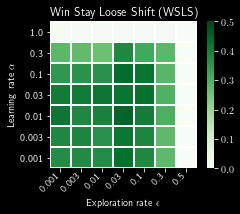

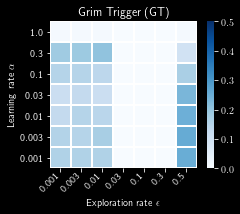

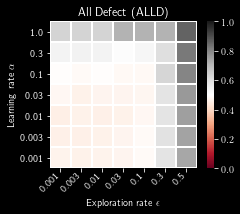

In [11]:
settings = {'text.usetex': True}
plt.rcParams.update(settings)

dcf = 0.99

plt.figure(figsize=(3.5,3))
aux_plot_grid(
df[df.df == dcf].pivot_table(columns='lr', index='er', values='avgWSLS').T, cmap='Greens', vmin=0, vmax=0.5)
ax=plt.gca()
ax.set_xlabel(u'Exploration rate $\epsilon$')
ax.set_ylabel(u'Learning rate $\\alpha$')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right',
                   position=(0, 0.025))
ax.set_title('Win Stay Loose Shift (WSLS)')
plt.subplots_adjust(bottom=0.2, left=0.15, right=0.95)
plt.savefig(f'figs/GridAvgWSLS_df{dcf}_'+env.id()+'.png', dpi=300)


plt.figure(figsize=(3.5,3))
aux_plot_grid(
df[df.df == dcf].pivot_table(columns='lr', index='er', values='avgGT').T, cmap='Blues', vmin=0, vmax=0.5)
ax=plt.gca()
ax.set_xlabel(u'Exploration rate $\epsilon$')
ax.set_ylabel(u'Learning rate $\\alpha$')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right',
                   position=(0, 0.025))
ax.set_title('Grim Trigger (GT)')
plt.subplots_adjust(bottom=0.2, left=0.15, right=0.95)
plt.savefig(f'figs/GridAvgGT_df{dcf}_'+env.id()+'.png', dpi=300)

plt.figure(figsize=(3.5,3))
aux_plot_grid(
df[df.df == dcf].pivot_table(columns='lr', index='er', values='avgALLD').T, cmap='RdGy', vmin=0.0, vmax=1.0)
ax=plt.gca()
ax.set_xlabel(u'Exploration rate $\epsilon$')
ax.set_ylabel(u'Learning rate $\\alpha$')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right',
                   position=(0, 0.025))
ax.set_title('All Defect (ALLD)')
plt.subplots_adjust(bottom=0.2, left=0.15, right=0.95)
plt.savefig(f'figs/GridAvgALLD_df{dcf}_'+env.id()+'.png', dpi=300)
